In [1]:
import pandas as pd
import pymysql 
import sqlite3

In [3]:
data = pd.read_excel('~/Data_Python/для когортного.xlsx')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3345 entries, 0 to 3344
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   deal_num      3345 non-null   int64         
 1   client ID     3345 non-null   int64         
 2   deal_date     3345 non-null   datetime64[ns]
 3   payment_date  3310 non-null   datetime64[ns]
 4   status        3345 non-null   object        
 5   sum           3345 non-null   int64         
 6   manager_id    3345 non-null   int64         
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 183.1+ KB


In [5]:
data.sample(3)

,deal_num,client ID,deal_date,payment_date,status,sum,manager_id
1408,27717,3823,2020-03-12,2020-04-30,Выигран,1500000,4
1296,28903,6668,2020-03-10,2020-03-28,Выигран,1200000,4
739,27668,2913,2020-02-18,2020-06-17,Выигран,150000,6


In [8]:
conn = sqlite3.connect('sql_test.db')

In [9]:
data.to_sql('dt_sql', conn, if_exists='replace', index=False)

C:\Users\Guzel\anaconda3\lib\site-packages\pandas\core\generic.py:2869: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [10]:
def fetch_query(sql):
    try: 
        conn = sqlite3.connect('sql_test.db')
        return pd.read_sql_query(sql, conn)
    except Exception as t:
        print (t)
    finally:
        conn.close()

In [43]:
sql = """
SELECT *, 
row_number() over (partition by "client ID" order by date(deal_date) desc) as row_number 
FROM dt_sql
""" 
fetch_query(sql)

,deal_num,client ID,deal_date,payment_date,status,sum,manager_id,row_number
0,30115,3,2020-04-13 00:00:00,2020-05-20 00:00:00,Выигран,2000000,5,1
1,28120,4,2020-02-23 00:00:00,2020-06-17 00:00:00,Выигран,1500000,4,1
2,25285,5,2020-04-27 00:00:00,2020-05-20 00:00:00,Выигран,1500000,7,1
3,27297,5,2020-04-12 00:00:00,2020-05-20 00:00:00,Выигран,500000,7,2
4,23932,5,2020-04-02 00:00:00,2020-04-19 00:00:00,Выигран,1300000,7,3
...,...,...,...,...,...,...,...,...
3340,30062,7102,2020-03-22 00:00:00,2020-04-03 00:00:00,Выигран,1050000,3,1
3341,35072,7106,2020-05-03 00:00:00,2020-05-20 00:00:00,Выигран,600000,2,1
3342,26879,7106,2020-04-14 00:00:00,2020-05-20 00:00:00,Выигран,2250000,6,2
3343,35424,7106,2020-01-27 00:00:00,2020-03-10 00:00:00,Выигран,1500000,3,3


In [74]:
a=pd.read_sql_query(
"""
SELECT *, strftime('%m', deal_date) as month_num,
strftime('%m', payment_date) as pay_month,
min(strftime('%m', payment_date)) over win1 as cohort
FROM dt_sql
WINDOW win1 AS (PARTITION BY "client ID" ORDER BY payment_date)

""", 
con = conn)

a

,deal_num,client ID,deal_date,payment_date,status,sum,manager_id,month_num,pay_month,cohort
0,30115,3,2020-04-13 00:00:00,2020-05-20 00:00:00,Выигран,2000000,5,04,05,05
1,28120,4,2020-02-23 00:00:00,2020-06-17 00:00:00,Выигран,1500000,4,02,06,06
2,44871,5,2020-02-11 00:00:00,2020-02-28 00:00:00,Отменен,6000000,10,02,02,02
3,23906,5,2020-03-22 00:00:00,2020-04-03 00:00:00,Выигран,1250000,7,03,04,02
4,26792,5,2020-03-24 00:00:00,2020-04-03 00:00:00,Выигран,350000,2,03,04,02
...,...,...,...,...,...,...,...,...,...,...
3340,30062,7102,2020-03-22 00:00:00,2020-04-03 00:00:00,Выигран,1050000,3,03,04,04
3341,35424,7106,2020-01-27 00:00:00,2020-03-10 00:00:00,Выигран,1500000,3,01,03,03
3342,26879,7106,2020-04-14 00:00:00,2020-05-20 00:00:00,Выигран,2250000,6,04,05,03
3343,35072,7106,2020-05-03 00:00:00,2020-05-20 00:00:00,Выигран,600000,2,05,05,03


In [75]:
a = pd.read_sql_query(
"""
with cohorts as
(SELECT *, strftime('%m', deal_date) as month_num,
strftime('%m', payment_date) as pay_month,
min(strftime('%m', payment_date)) over win1 as cohort, 
row_number () over win2 as rn
FROM dt_sql
WINDOW win1 AS (PARTITION BY "client ID" ORDER BY payment_date),
       win2 AS (PARTITION BY "client ID", "month_num" ORDER BY payment_date))
select 
cohort
,pay_month
,count(distinct "client ID") as Cohort_size
from cohorts
where pay_month >0
group by cohort, pay_month 
""", 
con = conn)
a

,cohort,pay_month,Cohort_size
0,01,01,21
1,01,02,1
2,01,03,3
3,01,04,7
4,01,05,3
5,01,06,2
6,02,02,246
7,02,03,38
8,02,04,65
9,02,05,26


In [76]:
a.to_excel("cohort_output.xlsx")  

In [77]:
table = pd.pivot_table(a, values='Cohort_size', index=['cohort'],
                    columns=['pay_month'])

In [78]:
table

pay_month,01,02,03,04,05,06
cohort,,,,,,
01,21.0,1.0,3.0,7.0,3.0,2.0
02,NaN,246.0,38.0,65.0,26.0,10.0
03,NaN,NaN,572.0,158.0,82.0,42.0
04,NaN,NaN,NaN,931.0,134.0,27.0
05,NaN,NaN,NaN,NaN,424.0,18.0
06,NaN,NaN,NaN,NaN,NaN,92.0


In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
# sns.heatmap?

<AxesSubplot:xlabel='pay_month', ylabel='cohort'>

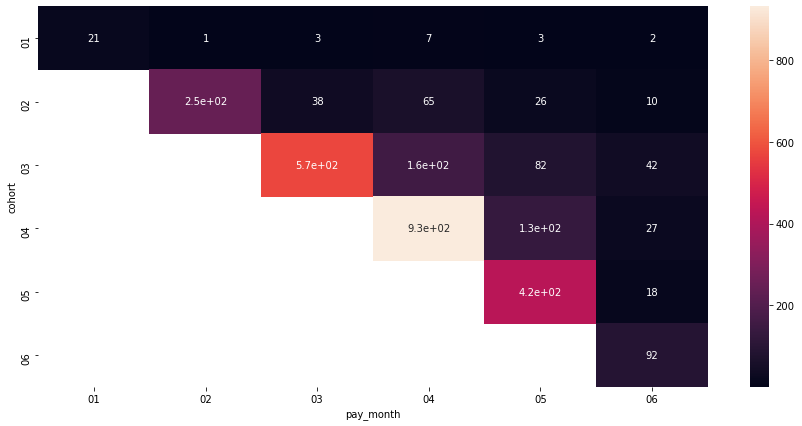

In [80]:
plt.figure (figsize=(15,7))
sns.heatmap(table, annot = True)